In [4]:
import os                                                   #for inferring the datasets
import tensorflow as tf                                     
import numpy as np
from PIL import Image , ImageOps                            #for reading the image , and processing them
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split                                                                                                                                                                                                

In [6]:
color_path = r"C:\Users\91956\OneDrive\Desktop\AI ML\DATASETS\landscape Images\color"
gray_path = r"C:\Users\91956\OneDrive\Desktop\AI ML\DATASETS\landscape Images\gray"

In [7]:
max_images = 2000           #set maximum images you'd want to infer from the 7,000 pairs of images
def prepare_data(path):     #takes the path of gray coloured images as argument
    images = []             #empty list for appending images
    i=0
    for file in os.listdir(path):       #os.listdir() is used to read the path as a directory in python
        if i==max_images:
            break
        img = Image.open(os.path.join(path,file))       #PIL lib Image for reading an image
        img = img.resize((200,200))                     #resizing for better preprocessing
        if path == gray_path:
            img = ImageOps.grayscale(img)               #convert gray images to grayscale
        img_array = np.array(img) / 255.0               #normalising the pixel values
        images.append(img_array)                        #adding to image array
        i = i+1
    return np.array(images)                             #return numpy array of color and gray images

In [8]:
color_images = prepare_data(color_path)
gray_images = prepare_data(gray_path)

In [7]:
color_images.shape

(2000, 200, 200, 3)

In [8]:
gray_images.shape

(2000, 200, 200)

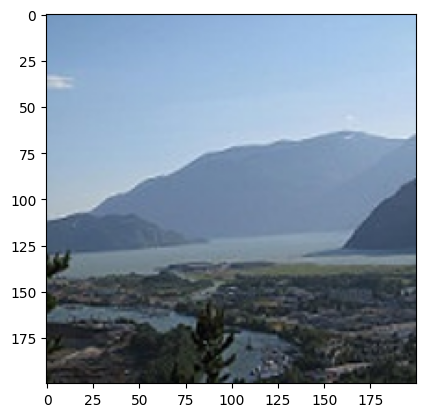

In [9]:
eg_color_image = color_images[1337]
plt.imshow(eg_color_image)

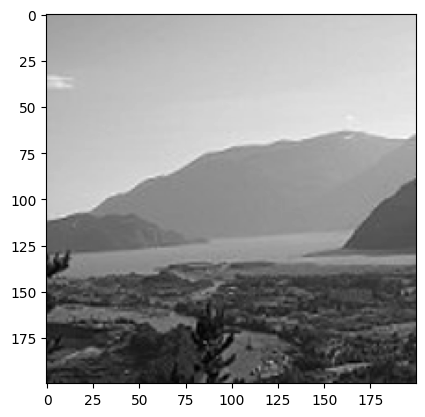

In [10]:
eg_gray_image = gray_images[1337]
plt.imshow(eg_gray_image,cmap='gray')

In [16]:
X_train,X_test,Y_train,Y_test = train_test_split(gray_images,color_images,test_size=0.2,random_state=42)

In [17]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (1600, 200, 200)
X_test shape: (400, 200, 200)
Y_train shape: (1600, 200, 200, 3)
Y_test shape: (400, 200, 200, 3)


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [13]:
def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(c7)

    model = models.Model(inputs, outputs)
    return model

# Define input shape
input_shape = (200, 200, 1)

# Build the model
model = build_unet(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [19]:
class DisplayCallback(tf.keras.callbacks.Callback):     #Custom callback function for keeping progress track of the model
    def __init__(self, X_test, Y_test):
        self.X_test = X_test
        self.Y_test = Y_test
    
    def on_epoch_end(self, epoch, logs=None):
        # Select a random test image
        idx = np.random.randint(0, self.X_test.shape[0])
        gray_img = self.X_test[idx]
        actual_color_img = self.Y_test[idx]
        
        # Predict the color image
        predicted_color_img = self.model.predict(gray_img[np.newaxis, ...])[0]
        
        # Plot the grayscale input, actual color image, and predicted color image
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title('Grayscale Input')
        plt.imshow(gray_img.reshape(200, 200), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Actual Color Image')
        plt.imshow(actual_color_img)
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Predicted Color Image')
        plt.imshow(predicted_color_img)
        plt.axis('off')

        plt.show()

# Instantiate the callback
display_callback = DisplayCallback(X_test, Y_test)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step - accuracy: 0.3319 - loss: 0.056


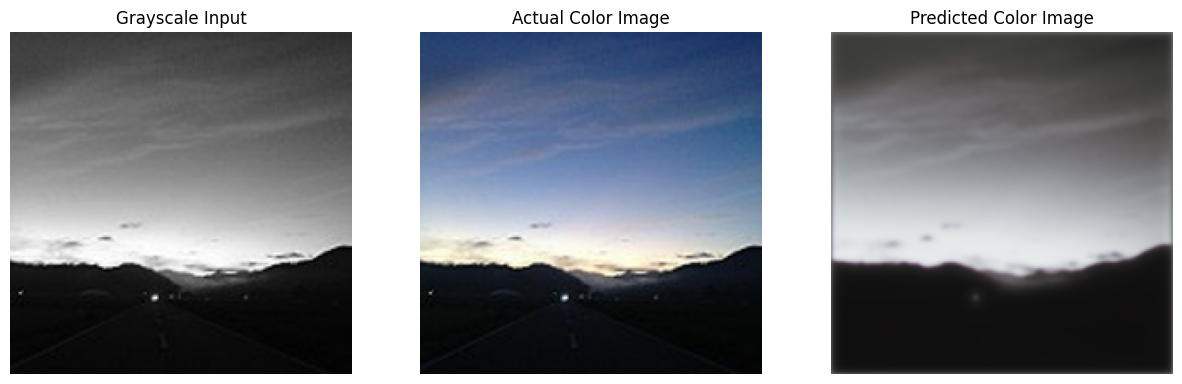

40/40 ━━━━━━━━━━━━━━━━━━━━ 1517s 38s/step - accuracy: 0.3320 - loss: 0.0557 - val_accuracy: 0.4514 - val_loss: 0.0133
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.4031 - loss: 0.013


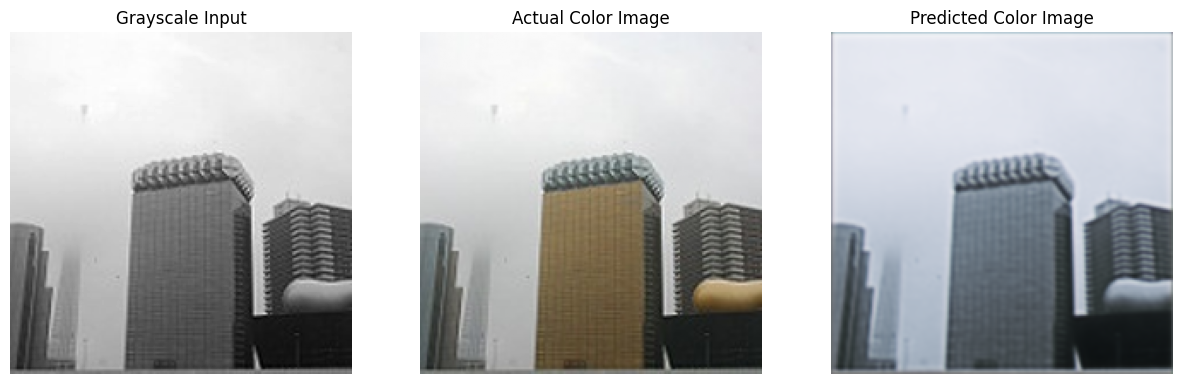

40/40 ━━━━━━━━━━━━━━━━━━━━ 811s 20s/step - accuracy: 0.4024 - loss: 0.0131 - val_accuracy: 0.4589 - val_loss: 0.0101
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.3765 - loss: 0.010


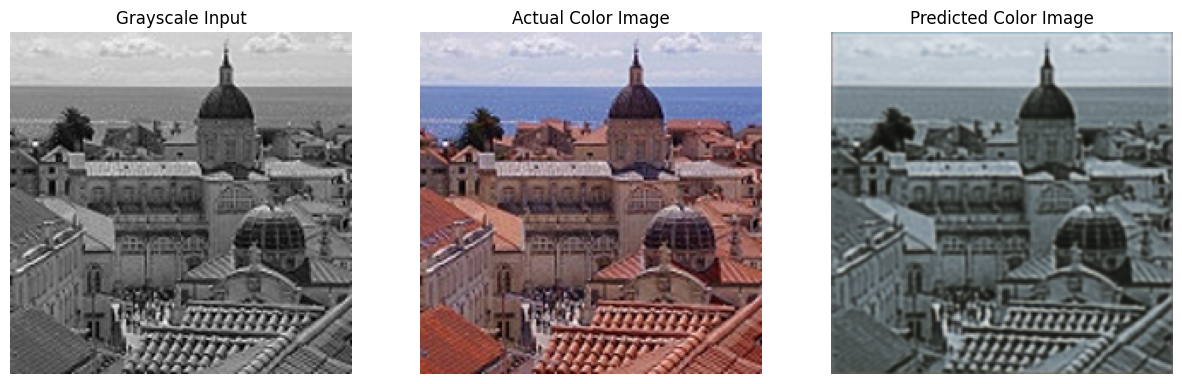

40/40 ━━━━━━━━━━━━━━━━━━━━ 782s 20s/step - accuracy: 0.3764 - loss: 0.0103 - val_accuracy: 0.4387 - val_loss: 0.0086
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.3803 - loss: 0.009


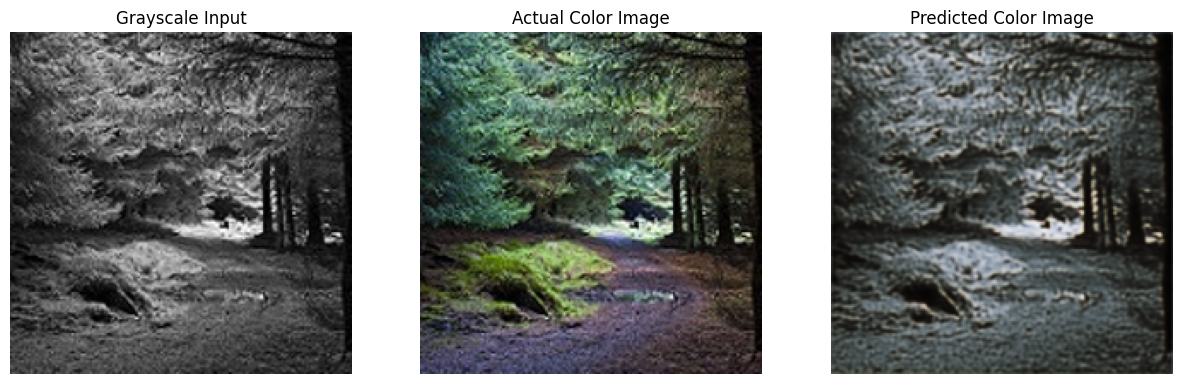

40/40 ━━━━━━━━━━━━━━━━━━━━ 1435s 36s/step - accuracy: 0.3807 - loss: 0.0091 - val_accuracy: 0.4843 - val_loss: 0.0075
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.4572 - loss: 0.007


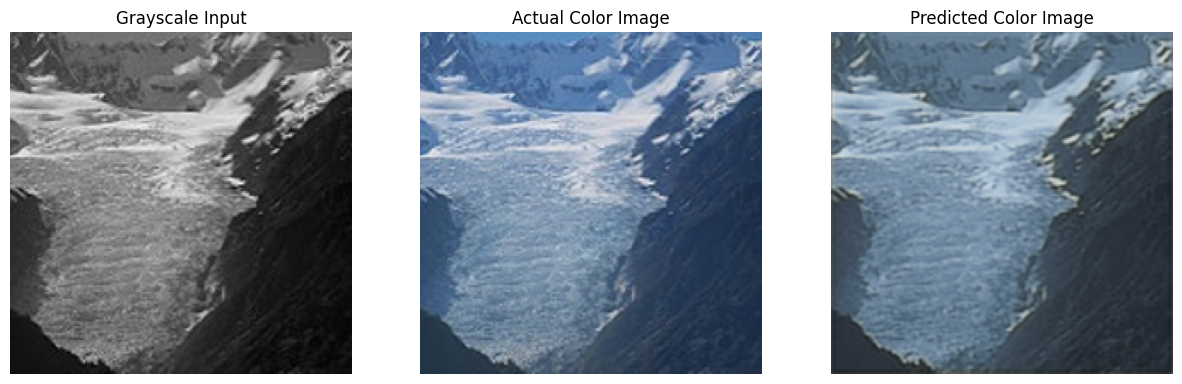

40/40 ━━━━━━━━━━━━━━━━━━━━ 1416s 36s/step - accuracy: 0.4569 - loss: 0.0079 - val_accuracy: 0.4763 - val_loss: 0.0079
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.4728 - loss: 0.007


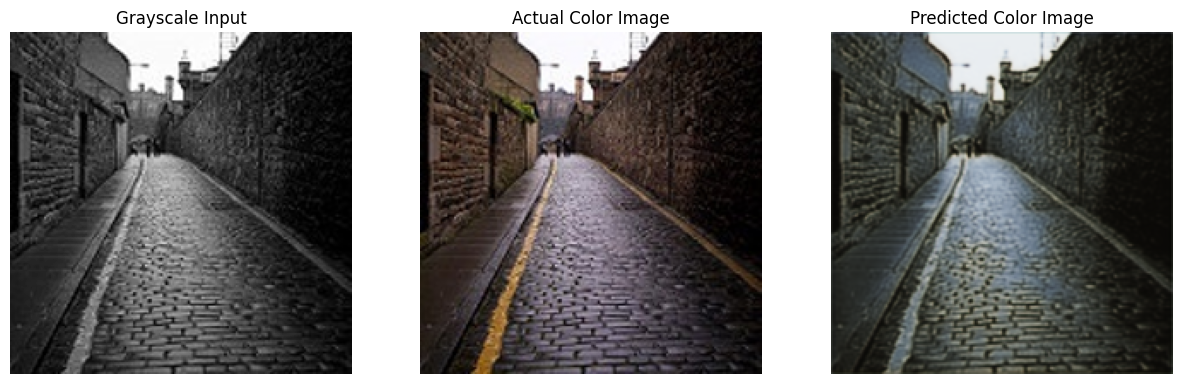

40/40 ━━━━━━━━━━━━━━━━━━━━ 1312s 33s/step - accuracy: 0.4722 - loss: 0.0075 - val_accuracy: 0.4991 - val_loss: 0.0069
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.4585 - loss: 0.007


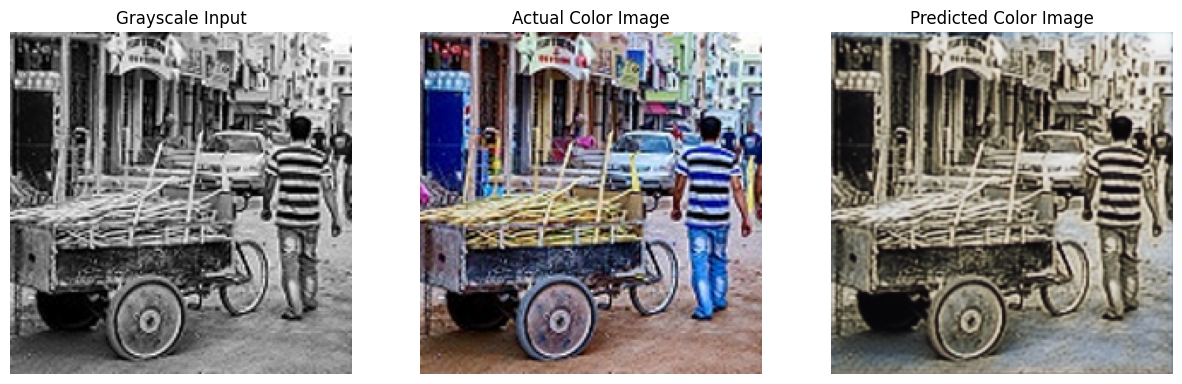

40/40 ━━━━━━━━━━━━━━━━━━━━ 1162s 29s/step - accuracy: 0.4585 - loss: 0.0071 - val_accuracy: 0.4950 - val_loss: 0.0061
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.4533 - loss: 0.006


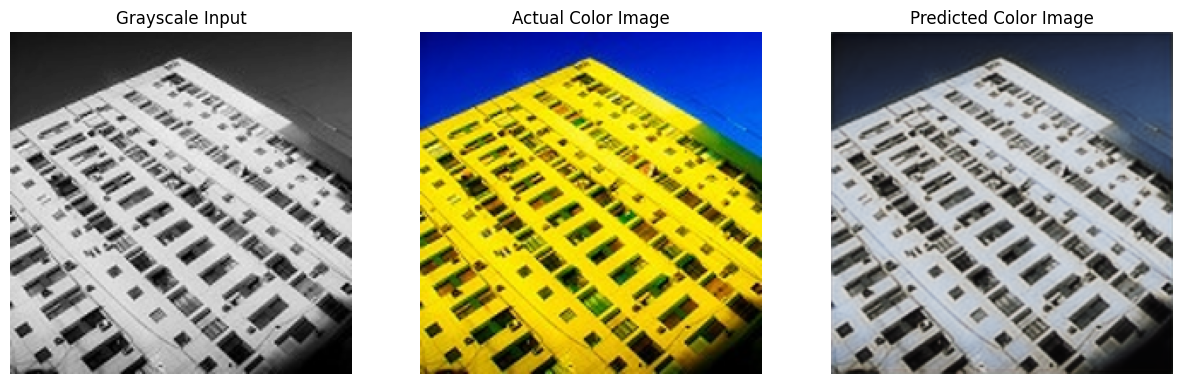

40/40 ━━━━━━━━━━━━━━━━━━━━ 1115s 28s/step - accuracy: 0.4535 - loss: 0.0069 - val_accuracy: 0.5206 - val_loss: 0.0059
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.4453 - loss: 0.006


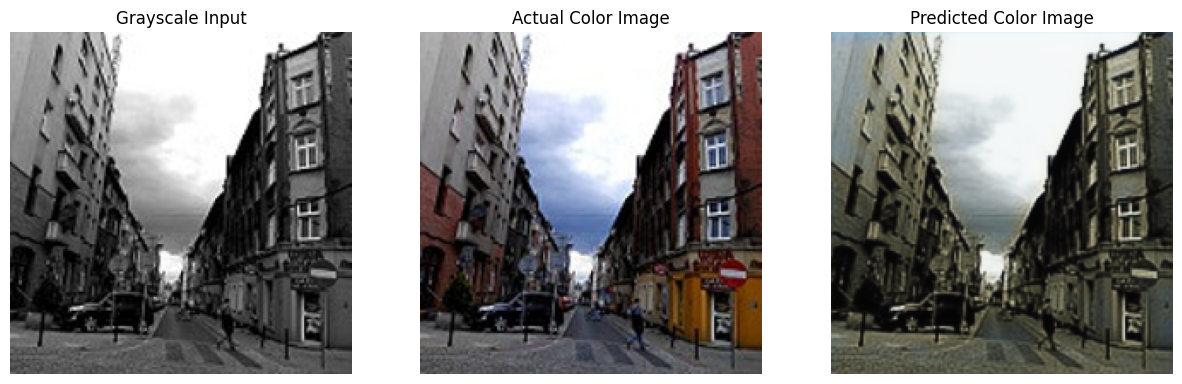

40/40 ━━━━━━━━━━━━━━━━━━━━ 716s 18s/step - accuracy: 0.4455 - loss: 0.0066 - val_accuracy: 0.4002 - val_loss: 0.0064
Epoch 10/10
 1/40 ━━━━━━━━━━━━━━━━━━━━ 11:24 18s/step - accuracy: 0.3882 - loss: 0.0071

KeyboardInterrupt: 

In [21]:
history = model.fit(X_train,Y_train,epochs = 10,batch_size = 32,validation_split = 0.2,callbacks = [display_callback])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


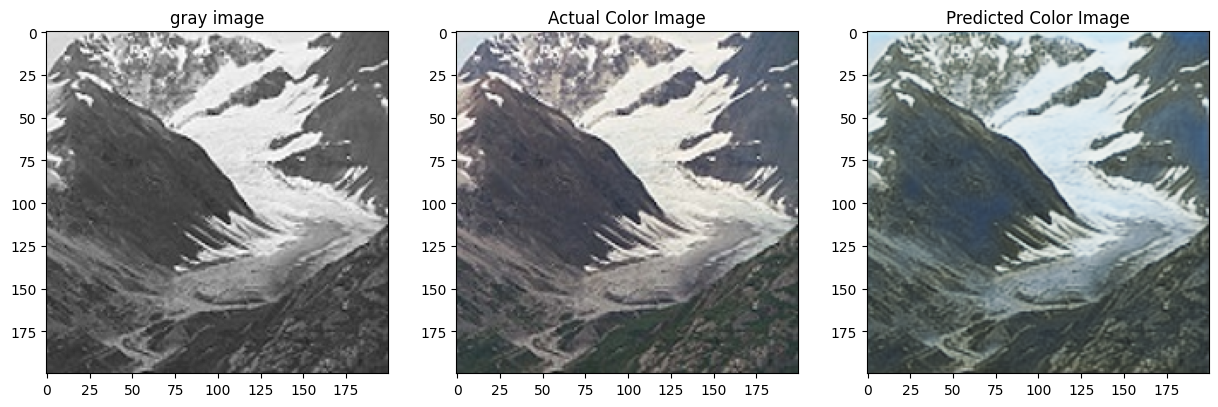

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


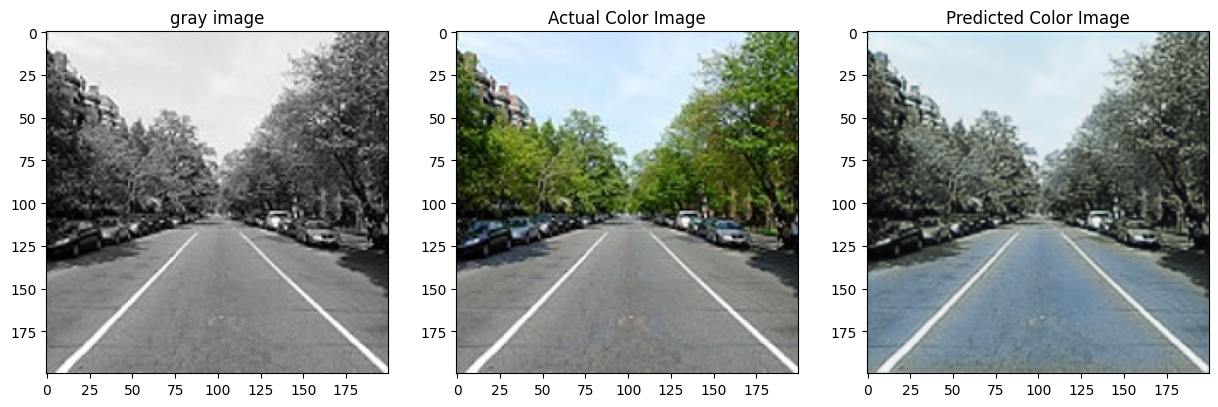

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


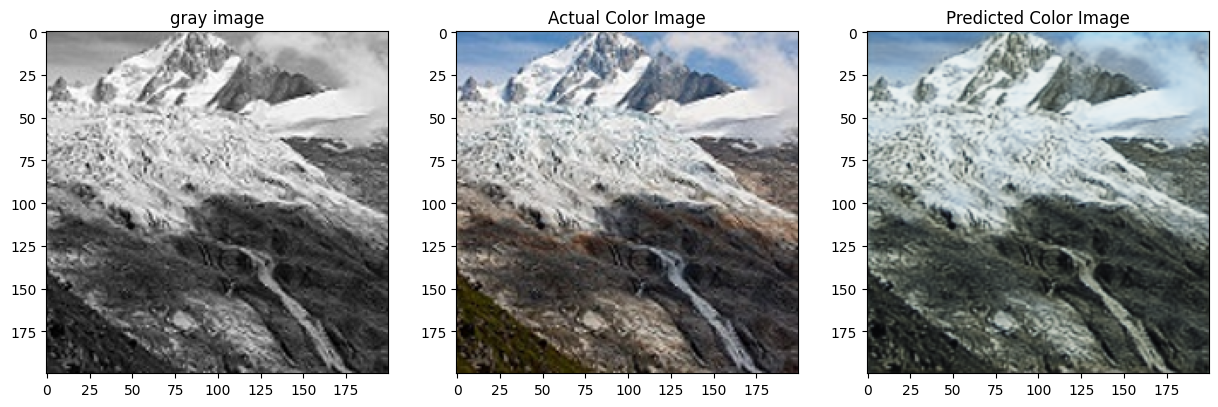

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


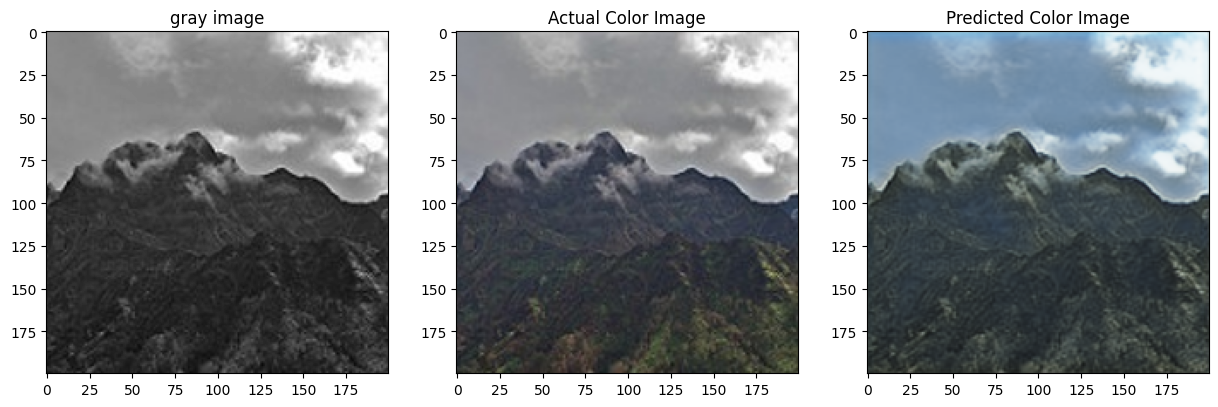

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


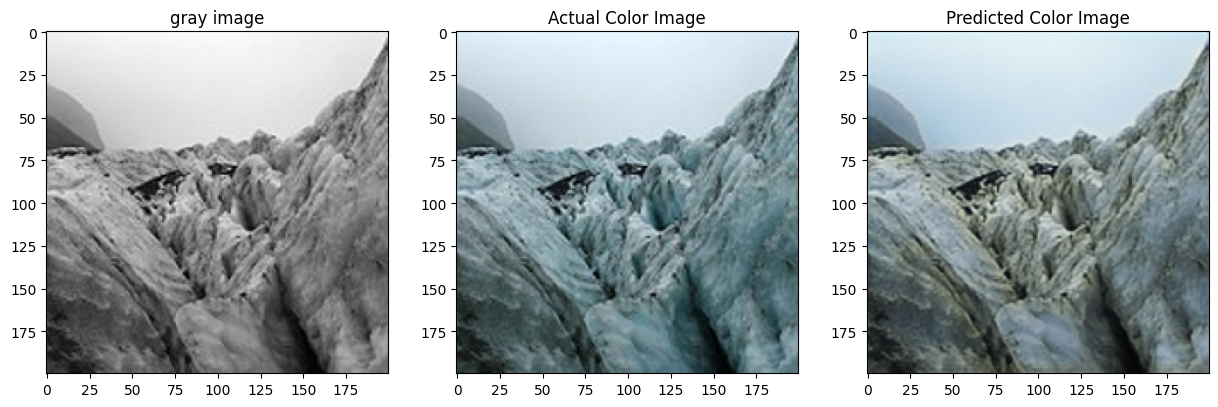

In [52]:
def visualize_predictions(model,X_test,Y_test,num_examples):
    for i in range(num_examples):
        index = np.random.randint(0, X_test.shape[0])                   #selecting a random index from the range of image arrays
        gray_img = X_test[index]
        color_img = Y_test[index]
        
        predicted  = model.predict(gray_img[np.newaxis, ...])[0]   #predicting for that specific gray image

        plt.figure(figsize=(15,30))

        plt.subplot(1,3,1)
        plt.title('gray image')
        plt.imshow(gray_img.reshape(gray_img.shape[0], gray_img.shape[1]), cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title('Actual Color Image')
        plt.imshow(color_img)

        plt.subplot(1, 3, 3)
        plt.title('Predicted Color Image')
        plt.imshow(predicted)

        plt.show()

examples = 5
visualize_predictions(model,X_test,Y_test,examples)
